#### **1) Libraries**

In [1]:
# Don't forget to restart
# !pip install -U tensorflow_probability -q
!pip install ipdb tensorflow==2.5.0 -q
!pip install git+https://github.com/tensorflow/docs -q

In [2]:
from IPython import display

import ipdb
import glob
import imageio
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import numpy as np
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import time
from tqdm import tqdm

from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.layers import Input, InputLayer, Lambda, Reshape, Dropout, \
                                    Flatten, Dense, Conv2D, Conv2DTranspose


In [3]:
pip list | grep tensorflow

tensorflow                    2.5.0                                         
tensorflow-datasets           4.0.1                                         
tensorflow-docs               0.0.07d6de2784363a81e65d5af245dc41b3e71eb65b5-
tensorflow-estimator          2.5.0                                         
tensorflow-gcs-config         2.5.0                                         
tensorflow-hub                0.12.0                                        
tensorflow-metadata           1.0.0                                         
tensorflow-probability        0.12.1                                        


In [4]:
if tf.test.gpu_device_name() != '/device:GPU:0':
    print('WARNING: GPU device not found.')
else:
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


In [5]:
# List all physical devices
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

If using Google Colab, save in your Google Drive.

In [6]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### **2) Extract Data**

In [7]:
# BATCH_SIZE = 32
BATCH_SIZE = 128

##### **2b) Fashion MNIST Data**

In [8]:
datasets, datasets_info = tfds.load(name='fashion_mnist',
                                    with_info=True,
                                    as_supervised=False
                                    )

In [9]:
def _preprocess(sample):
    image = tf.cast(sample['image'], tf.float32) / 255.  # Scale to unit interval.
    # image = tf.where(image > .5, 1.0, 0.0)
    return image

In [10]:
fm_train_dataset = (datasets['train']
                    .map(_preprocess)
                   .batch(BATCH_SIZE)
                   .prefetch(tf.data.experimental.AUTOTUNE)
                   .shuffle(60000)
                   )

fm_test_dataset = (datasets['test']
                  .map(_preprocess)
                  .batch(BATCH_SIZE)
                  .prefetch(tf.data.experimental.AUTOTUNE)
                  )

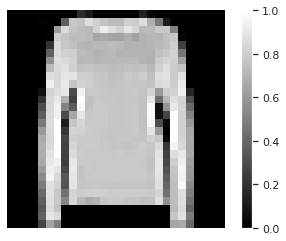

In [11]:
for train_batch in fm_train_dataset.take(1):
    image = train_batch[0].numpy()
image = np.squeeze(image, axis=2)

plt.figure()
plt.imshow(image, cmap='gray')
# plt.title('corresponding image label {}'.format(label))
plt.colorbar()
plt.grid(False)
plt.axis('off')
plt.show();

#### **3) Model Class**

Credit: https://www.tensorflow.org/api_docs/python/tf/keras/datasets

In [12]:
from tensorflow.keras import layers as tfkl

In [13]:
class Sampler_Z(tfkl.Layer):

    def call(self, inputs):
        mean, logvar = inputs
        # Reparameterize
        eps = tf.random.normal(shape=mean.shape)
        z_sample = eps * tf.exp(logvar * .5) + mean
        return z_sample

In [14]:
# Encoder/Decoder Model 3 (Fashion MNIST)
class EncoderZ_3(tfk.Model):

    def __init__(self, latent_dim, n_filter_base, name="encoder", **kwargs):
        super(EncoderZ_3, self).__init__(name=name, **kwargs)
        # Block-1
        self.conv_layer_1 = tfkl.Conv2D(filters=n_filter_base, kernel_size=3,
                                        strides=1, padding='same', name='conv_1'
                                        )
        self.batch_layer_1 = tfkl.BatchNormalization(name='bn_1')
        self.activation_layer_1 = tfkl.Activation(tf.nn.leaky_relu, name='lrelu_1')
        # Block-2
        self.conv_layer_2 = tfkl.Conv2D(filters=n_filter_base*2, kernel_size=3,
                                        strides=2, padding='same', name='conv_2'
                                        )
        self.batch_layer_2 = tfkl.BatchNormalization(name='bn_2')
        self.activation_layer_2 = tfkl.Activation(tf.nn.leaky_relu, name='lrelu_2')
        # Block-3
        self.conv_layer_3 = tfkl.Conv2D(filters=n_filter_base*2, kernel_size=3,
                                        strides=2, padding='same', name='conv_3'
                                        )
        self.batch_layer_3 = tfkl.BatchNormalization(name='bn_3')
        self.activation_layer_3 = tfkl.Activation(tf.nn.leaky_relu, name='lrelu_3')
        # Block-4
        self.conv_layer_4 = tfkl.Conv2D(filters=n_filter_base*2, kernel_size=3,
                                        strides=1, padding='same', name='conv_4'
                                        )
        self.batch_layer_4 = tfkl.BatchNormalization(name='bn_4')
        self.activation_layer_4 = tfkl.Activation(tf.nn.leaky_relu, name='lrelu_4')
        # Final Block
        self.flatten_layer = Flatten()
        self.dense_mean = Dense(latent_dim, activation=None, name='z_mean')
        self.dense_raw_stddev = Dense(latent_dim, activation=None,
                                      name='z_raw_stddev'
                                      )
        self.sampler_z = Sampler_Z()

    # Functional
    def call(self, x_input, training=False):
        z = self.conv_layer_1(x_input)
        z = self.batch_layer_1(z)
        z = self.activation_layer_1(z)
        z = self.conv_layer_2(z)
        z = self.batch_layer_2(z)
        z = self.activation_layer_2(z)
        z = self.conv_layer_3(z)
        z = self.batch_layer_3(z)
        z = self.activation_layer_3(z)
        z = self.conv_layer_4(z)
        z = self.batch_layer_4(z)
        z = self.activation_layer_4(z)
        z = self.flatten_layer(z)
        mean = self.dense_mean(z)
        logvar = self.dense_raw_stddev(z)
        z_sample = self.sampler_z((mean, logvar))
        return z_sample, mean, logvar


class DecoderX_3(tfk.Model):

    def __init__(self, latent_dim, n_filter_base, name="decoder", **kwargs):
        super(DecoderX_3, self).__init__(name=name, **kwargs)
        # For MNIST / Fashion MNIST images
        self.dense_z_input = tfkl.Dense(units=7*7*n_filter_base*2,
                                        activation=tf.nn.relu
                                        )
        self.reshape_layer = tfkl.Reshape(target_shape=(7, 7, n_filter_base*2))
        # For 0xflower images
        # self.dense_z_input = tfkl.Dense(units=56*56*n_filter_base*2,
        #                                 activation=tf.nn.relu
        #                                 )
        # self.reshape_layer = tfkl.Reshape(target_shape=(56, 56, n_filter_base*2))
        # Block-1
        self.conv_transpose_layer_1 = tfkl.Conv2DTranspose(filters=n_filter_base*2,
                                                           kernel_size=3,
                                                           strides=1, 
                                                           padding='same',
                                                           name='conv_transpose_1'
                                                           )
        self.batch_layer_1 = tfkl.BatchNormalization(name='bn_1')
        self.activation_layer_1 = tfkl.Activation(tf.nn.leaky_relu, name='lrelu_1')
        # Block-2
        self.conv_transpose_layer_2 = tfkl.Conv2DTranspose(filters=n_filter_base*2,
                                                           kernel_size=3,
                                                           strides=2, 
                                                           padding='same',
                                                           name='conv_transpose_2'
                                                           )
        self.batch_layer_2 = tfkl.BatchNormalization(name='bn_2')
        self.activation_layer_2 = tfkl.Activation(tf.nn.leaky_relu, name='lrelu_2')
        # Block-3
        self.conv_transpose_layer_3 = tfkl.Conv2DTranspose(filters=n_filter_base,
                                                           kernel_size=3,
                                                           strides=2, 
                                                           padding='same',
                                                           name='conv_transpose_3'
                                                           )
        self.batch_layer_3 = tfkl.BatchNormalization(name='bn_3')
        self.activation_layer_3 = tfkl.Activation(tf.nn.leaky_relu, name='lrelu_3')
        # Block-4
        # For MNIST / Fashion MNIST images
        self.conv_transpose_layer_4 = tfkl.Conv2DTranspose(filters=1,
                                                           kernel_size=3,
                                                           strides=1, 
                                                           padding='same',
                                                           name='conv_transpose_4'
                                                           )
        # For 0xflower images
        # self.conv_transpose_layer_4 = tfkl.Conv2DTranspose(filters=3,
        #                                                    kernel_size=3,
        #                                                    strides=1, 
        #                                                    padding='same',
        #                                                    name='conv_transpose_4'
        #                                                    )

    # Functional
    def call(self, z, training=False):
        x_output = self.dense_z_input(z)
        x_output = self.reshape_layer(x_output)
        x_output = self.conv_transpose_layer_1(x_output)
        x_output = self.batch_layer_1(x_output)
        x_output = self.activation_layer_1(x_output)
        x_output = self.conv_transpose_layer_2(x_output)
        x_output = self.batch_layer_2(x_output)
        x_output = self.activation_layer_2(x_output)
        x_output = self.conv_transpose_layer_3(x_output)
        x_output = self.batch_layer_3(x_output)
        x_output = self.activation_layer_3(x_output)
        x_output = self.conv_transpose_layer_4(x_output)
        return x_output

In [15]:
class VAEModel(tfk.Model):
    """Convolutional variational autoencoder base model."""

    def __init__(self, encoder, decoder, latent_dim, n_filter_base, **kwargs):
        super(VAEModel, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tfk.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tfk.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tfk.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    @tf.function
    def sample(self, z_sample):
        # z_sample, _, _ = self.encoder(x_sample)
        x_recons_logits = self.decoder(z_sample)
        sample_images = tf.sigmoid(x_recons_logits)  # predictions
        # sample_images = tf.math.sigmoid(x_recons_logits)  # predictions
        return sample_images

    # [KC] Problem 3:
    def train_step(self, data):
        """Executes one training step and returns the loss.

        This function computes the loss and gradients, and uses the latter to
        update the model's parameters.
        """
        # # Pick a sample of the test set for generating output images
        # # num_examples_to_generate = n_sample
        # assert batch_size >= n_sample
        # for test_batch in test_dataset.take(1):
        #     test_sample = test_batch[0:n_sample, :, :, :]

        with tf.GradientTape() as tape:
            loss = self.compute_loss(x_true)
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        # with tf.GradientTape() as tape:
        #     z_mean, z_log_var, z = self.encoder(data)
        #     reconstruction = self.decoder(z)
        #     reconstruction_loss = tf.reduce_mean(
        #         tf.reduce_sum(
        #             keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
        #         )
        #     )
        #     kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        #     kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        #     total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        # Need to use test data
        self.generate_and_save_images(epoch, test_sample)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def compute_loss(self, x_true):
        x_recons_logits, z_sample, mean, logvar = self.model(x_true)
        # Cross Entropy Loss 
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_recons_logits,
                                                            labels=x_true
                                                            )
        # Negative Log-Likelihood
        logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
        neg_ll = logpx_z
        # KL-Divergence
        logpz = self.log_normal_pdf(z_sample, 0., 1.)
        logqz_x = self.log_normal_pdf(z_sample, mean, logvar)
        kl_div = logqz_x - logpz
        # ELBO
        elbo = tf.math.reduce_mean(-kl_div + neg_ll)
        return -elbo

    def log_normal_pdf(self, sample, mean, logvar, raxis=1):
        log2pi = tf.math.log(2. * np.pi)
        return tf.reduce_sum(
            -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
            axis=raxis)

    # [KC] Problem 4:
    def generate_and_save_images(self, epoch, test_sample):
        z_sample, _, _ = self.model.encoder(test_sample)
        decoder_sample_images = self.model.sample(z_sample)  # predictions
        fig = plt.figure(figsize=(4, 4))

        for i in range(decoder_sample_images.shape[0]):
            plt.subplot(4, 4, i + 1)
            plt.imshow(decoder_sample_images[i, :, :, 0], cmap='gray')
            plt.axis('off')

        # tight_layout minimizes the overlap between 2 sub-plots
        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
        plt.show()

    '''
    def call(self, x_input):
        z_sample, mean, logvar = self.encoder(x_input)
        x_recons_logits = self.decoder(z_sample)
        return x_recons_logits, z_sample, mean, logvar
    '''


In [16]:
'''
class VAE:
    """Variational Autoencoder wrapper."""
    def __init__(self, image_dim, z_dim, n_filter_base=32, learning_rate=0.0005):
        self.optimizer = tfk.optimizers.Adam(learning_rate)
        self.loss_metric = tfk.metrics.Mean()
        self.model = VAEModel(z_dim, n_filter_base)

    def train(self, train_dataset, test_dataset, batch_size=0, 
              n_epoch=10, n_sample=4):
        # Pick a sample of the test set for generating output images
        # num_examples_to_generate = n_sample
        assert batch_size >= n_sample
        for test_batch in test_dataset.take(1):
            test_sample = test_batch[0:n_sample, :, :, :]

        self.generate_and_save_images(0, test_sample)
        for epoch in range(1, n_epoch + 1):
            start_time = time.time()
            for train_x in tqdm(train_dataset):
                self.train_step(train_x)
            end_time = time.time()

            loss = tfk.metrics.Mean()
            for test_x in test_dataset:
                loss(self.compute_loss(test_x))
            elbo = -loss.result()
            display.clear_output(wait=False)
            print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
                  .format(epoch, elbo, end_time - start_time)
                  )
            self.generate_and_save_images(epoch, test_sample)

    @tf.function
    def train_step(self, x_true):
        """Executes one training step and returns the loss.

        This function computes the loss and gradients, and uses the latter to
        update the model's parameters.
        """
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x_true)
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

    def log_normal_pdf(self, sample, mean, logvar, raxis=1):
        log2pi = tf.math.log(2. * np.pi)
        return tf.reduce_sum(
            -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
            axis=raxis)

    def compute_loss(self, x_true):
        x_recons_logits, z_sample, mean, logvar = self.model(x_true)
        # Cross Entropy Loss 
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_recons_logits,
                                                            labels=x_true
                                                            )
        # Negative Log-Likelihood
        logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
        neg_ll = logpx_z
        # KL-Divergence
        logpz = self.log_normal_pdf(z_sample, 0., 1.)
        logqz_x = self.log_normal_pdf(z_sample, mean, logvar)
        kl_div = logqz_x - logpz
        # ELBO
        elbo = tf.math.reduce_mean(-kl_div + neg_ll)
        return -elbo

    def generate_and_save_images(self, epoch, test_sample):
        z_sample, _, _ = self.model.encoder(test_sample)
        decoder_sample_images = self.model.sample(z_sample)  # predictions
        fig = plt.figure(figsize=(4, 4))

        for i in range(decoder_sample_images.shape[0]):
            plt.subplot(4, 4, i + 1)
            plt.imshow(decoder_sample_images[i, :, :, 0], cmap='gray')
            plt.axis('off')

        # tight_layout minimizes the overlap between 2 sub-plots
        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
        plt.show()
'''

#### **4) Models Train**

In [18]:
fm_train_dataset

<ShuffleDataset shapes: (None, 28, 28, 1), types: tf.float32>

In [19]:
# vae init params
input_dim = 28  # image dim
image_dim = (28, 28, 1)
# image_dim = (224, 224, 3)
z_dim = 2  # latent dim, set the dimensionality of the latent space to a plane for visualization later
n_filter_base = 32  # number of base filters in the CNN (a lot of filters?)
learning_rate = 0.0005  # uses for the internal Adam opt

# vae.train params
n_epoch = 10  # number of epochs
batch_size = BATCH_SIZE
show_display = True
display_sample = False
n_sample = 16  # number of example outputs to sample and generate, also n_display

In [21]:
# Error 1: 
encoder = EncoderZ_3(z_dim, n_filter_base)
encoder.summary()

ValueError: ignored

In [ ]:
decoder = DecoderX_3(z_dim, n_filter_base)

In [25]:
vae = VAEModel(encoder, decoder, image_dim, z_dim)

In [26]:
vae.compile(optimizer=tfk.optimizers.Adam())

In [27]:
# [KC] Problem 2:
type(fm_train_dataset), type(fm_test_dataset)

(tensorflow.python.data.ops.dataset_ops.ShuffleDataset,
 tensorflow.python.data.ops.dataset_ops.PrefetchDataset)

In [29]:
# What Keras does
(x_train, _), (x_test, _) = tfk.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

11493376/11490434 [==============================] - 0s 0us/step


In [30]:
type(x_train), type(mnist_digits)

(numpy.ndarray, numpy.ndarray)

In [28]:
vae.fit(fm_train_dataset, epochs=30, batch_size=128)

Epoch 1/30


ValueError: ignored

In [ ]:
# %%time
# vae.train(fm_train_dataset, fm_test_dataset, batch_size, n_epoch, n_sample)

#### **5) Models Display**

In [ ]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
plt.imshow(display_image(n_epoch))
plt.axis('off')  # Display images

In [ ]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [ ]:
def plot_latent_images(model, n, digit_size=28):
    """Plots n x n digit images decoded from the latent space."""
    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    image_width = digit_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            x_decoded = model.sample(z)
            digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
            image[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()

In [ ]:
plot_latent_images(vae.model, 20)